# RBF Network with Kmeans Clustering

K-means Clustering과 함께 RBF를 사용할 경우 데이터가 적고 대표하지 못할 경우 성능이 낮게 나올 수 있음.

# Input

Using python3.6, Anaconda, Windows10

In [1]:
import os, sys
import numpy as np
import pandas as pd
import six.moves.cPickle as pickle
import gzip
import time
import scipy.misc

In [2]:
from matplotlib.pyplot import cm

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
def load_file(file_name, col_names=None):
    data_dir = 'train_test_files'
    file_path = os.path.join(data_dir, file_name)
    df = pd.read_csv(file_path, sep='\t', names=col_names)
    return df.iloc[:,:-1].values, df.iloc[:,-1].values

In [116]:
cis_train1_x, cis_train1_y = load_file('cis_train1.txt', ['circles', 'squares', 'labels'])
cis_train2_x, cis_train2_y = load_file('cis_train2.txt', ['circles', 'squares', 'labels'])
cis_train_x = np.concatenate((cis_train1_x, cis_train2_x))
cis_train_y = np.concatenate((cis_train1_y, cis_train2_y))
cis_test_x, cis_test_y = load_file('cis_test.txt', ['circles', 'squares', 'labels'])

In [115]:
fa_train1_x, fa_train1_y = load_file('fa_train1.txt', ['f', 'a'])
fa_train2_x, fa_train2_y = load_file('fa_train2.txt', ['f', 'a'])
fa_train_x = np.concatenate((fa_train1_x, fa_train2_x))
fa_train_y = np.concatenate((fa_train1_y, fa_train2_y))
fa_test_x, fa_test_y = load_file('fa_test.txt', ['f', 'a'])

# Step 1: K-Means Algorithm

In [84]:
class Kmeans:
    def __init__(self, k, data, no_iter=100, optimized=True):
        self.k = k
        total_loss = []
        # Random initialization
        cluster_centers = np.random.random([k, data.shape[-1]])
        # Calculate Distance of each point to every cluster centers.
        dist_vec = np.zeros([k, data.shape[0]])
        cur = 0
        while(cur < no_iter):
            for idx, _center in enumerate(cluster_centers):
                dist_vec[idx] = np.sum(np.square(np.subtract(np.broadcast_to(_center, data.shape), data)), axis=1) # (50000, )
            # Determine Argmin center
            labels = np.argmin(dist_vec, axis=0)
            loss = 0
            for idx in range(k):
                # Check Cluster Balance
                if data[labels == idx].shape[0] < 2: # Degrees should be greater than 0
                    cluster_centers = np.random.random([k, data.shape[-1]])
                    cur = -1
                    break
                # Calculate Loss J
                loss += np.sum(dist_vec[idx][labels == idx])
                # Update cluster centers
                cluster_centers[idx] = np.average(data[labels == idx], axis=0) # dim 784
            if cur >= 0:
                total_loss.append(loss)
            if optimized and cur > 1 and (total_loss[-1] == total_loss[-2]):
                break
            cur += 1
        print('Iterations: {}'.format(len(total_loss)))
        self.centers, self.labels, self.total_loss = cluster_centers, labels, total_loss
    
    def predict(self, data):
        dist_vec = np.zeros([self.k, data.shape[0]])
        for idx, _center in enumerate(self.centers):
            dist_vec[idx] = np.sum(np.square(np.subtract(np.broadcast_to(_center, data.shape), data)), axis=1) # (50000, )
        return np.argmin(dist_vec, axis=0)
    

Iterations: 23


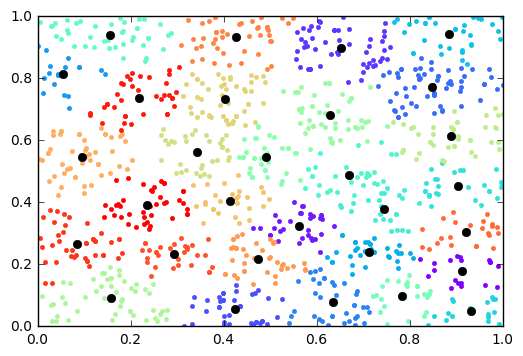

In [122]:
k = 30
kmeans = Kmeans(k, cis_train_x)
fig = plt.figure
color=iter(cm.rainbow(np.linspace(0,1,k)))
pred = kmeans.predict(cis_train_x)
for i in range(k):
    c = next(color)
    plt.plot(cis_train_x[pred == i][:,0], cis_train_x[pred == i][:,1], '.', c=c)
    plt.plot(kmeans.centers[i,0], kmeans.centers[i,1], 'ko')

# Step 2: RBF Network

In [195]:
class RBFNetwork:
    def __init__(self, no_basis, no_labels, learning_rate=0.01):
        self.no_basis = no_basis
        self.no_labels = no_labels
        self.mu, self.sigma = np.zeros([0]), np.zeros([0])
        self.weights = np.random.normal(0, 0.05, [no_basis+1, no_labels]) # including bias 1
        self.output = np.zeros([0])
        self.loss = 0
        
    def train(self, data, labels):
        self._back_propagate(data, labels)
        self.loss = self.get_loss(data, labels)
        print("RBF Loss(MSE): {:.4f}".format(self.loss))
           
    def predict(self, data):
        self._propagate(data)
        return self.output
    
    def get_loss(self, data, labels):
        # Return: MSE loss
        return np.mean(np.square(self.predict(data) - labels))
    
    def test(self, data, labels, threshold=None):
        if threshold:
            return np.mean((self.predict(data) > threshold).astype(np.int16) == labels)
        return self.get_loss(data, labels)
    
    def _propagate(self, data):
        # initial propagate
        if not self.mu.any():
            self.mu, self.sigma = self._calculate_param(self.no_basis, data)
        self.basis = np.zeros([data.shape[0], self.no_basis+1])
        self.basis[:,0] = np.ones([data.shape[0]]) # for Bias
        # apply RBF kernels
        for i in range(data.shape[0]):
            self.basis[i,1:] = self._gaussian_kernels(data[i], self.mu, self.sigma)
        # output
        self.output = np.dot(self.basis, self.weights) # (no_data, no_labels)
                
    def _back_propagate(self, data, labels):
        self._propagate(data)
        self.weights = np.dot(np.dot(np.linalg.pinv(np.dot(self.basis.T, self.basis)), self.basis.T), labels)
    
    def _calculate_param(self, k, data):
        # Calculate means & variances using K-Means Clustering
        print("Kmeans Training")
        kmeans = Kmeans(k, data)
        cluster_means, cluster_vars = [], []
        for i in range(k):
            cluster_elements = data[kmeans.predict(data) == i]
            cluster_means.append(np.mean(cluster_elements, axis=0))
            if data.ndim == 1 or data.shape[-1] == 1: # univariate
                cluster_vars.append(np.var(cluster_elements))
            else: # multivariate
                cluster_vars.append(np.linalg.pinv(np.cov(cluster_elements.T)))
        print("Kmeans Training Complete")
        return np.array(cluster_means), np.array(cluster_vars)
    
    def _gaussian_kernels(self, x, mu, sigma):
        if mu.ndim == 1:
            hidden_nodes = np.zeros(mu.shape[0])
            for j in range(mu.shape[0]): # (k,dim)
                return np.exp(-np.divide(np.square(x-mu[j]), 2*np.square(sigma[j])))
            return hidden_nodes
        else:
            hidden_nodes = np.zeros(mu.shape[0])
            for j in range(mu.shape[0]): # (k,dim)
                # (X-u).T*Sigma*(X-u)
                hidden_nodes[j] = np.exp(-np.divide(np.dot(np.dot((x-mu[j]).T, sigma[j]), x-mu[j]),2))
            return hidden_nodes

# Circle in Square Data

In [339]:
rbf = RBFNetwork(no_basis=100, no_labels=1)
rbf.train(cis_train_x, cis_train_y)

Kmeans Training
Iterations: 21
Kmeans Training Complete
RBF Loss(MSE): 0.0608


In [340]:
print('Training Accuracy: {:.4f}'.format(rbf.test(cis_train1_x, cis_train1_y, 0.5)))
print('Training Accuracy: {:.4f}'.format(rbf.test(cis_train2_x, cis_train2_y, 0.5)))
print('Test Accuracy: {:.4f}'.format(rbf.test(cis_test_x, cis_test_y, 0.5)))

Training Accuracy: 0.9700
Training Accuracy: 0.9650
Test Accuracy: 0.9387


# Function Approximation Data

In [343]:
rbf = RBFNetwork(no_basis=10, no_labels=1)
rbf.train(fa_train_x, fa_train_y)

Kmeans Training
Iterations: 6
Kmeans Training Complete
RBF Loss(MSE): 0.0344


In [344]:
print('Training-1 MSE Loss: {:.4f}'.format(rbf.test(fa_train1_x, fa_train1_y)))
print('Training-2 MSE Loss: {:.4f}'.format(rbf.test(fa_train2_y, fa_train2_y)))
print('Test MSE Loss: {:.4f}'.format(rbf.test(fa_test_x, fa_test_y)))

Training-1 MSE Loss: 0.0310
Training-2 MSE Loss: 0.0197
Test MSE Loss: 0.0313
